In [1]:
# incorporate drift into the LV model and see if we can find anything interesting

In [2]:
import torch
import pickle
import os.path
import numpy as np
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

import utils as mutils
import lvutils as lv
import mattplotlib as m
import matth as math
import model

def redo():
    reload(mutils)
    reload(lv)
    reload(m)
    reload(math)
    reload(model)

Invoking __init__.py for NDNT.utils


In [3]:
print('running')

running


# load the data

In [4]:
data = mutils.load_data('ki_0126_V2_py.mat')

../../data/hn/ ki_0126_V2_py.mat
Loaded ki_0126_V2_py.mat
190541 frames, 26 units, 870 trials with 192 frames each
  Time embedding...
  Time embedding...


# train the drift model

In [5]:
redo()
LLsNULL, drift_net, drift_mod = model.train_drift(data)

Mean LL-null: 2.005847


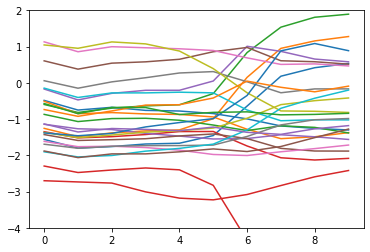

In [6]:
dw = drift_mod.get_weights()
plt.plot(dw)
plt.ylim([-4, 2])
plt.show()

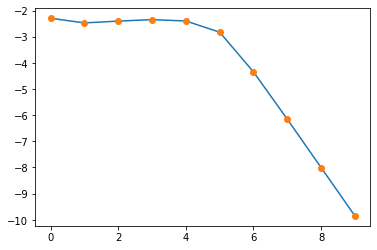

In [7]:
plt.plot(dw[:,3])
plt.plot(dw[:,3],'o')
plt.show()

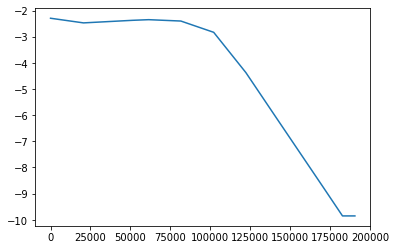

In [8]:
plt.plot(data.Xdrift.numpy()@dw[:,3])

# train the GLM+drift network

In [9]:
redo()
LLs0, glm = model.train_glm_with_drift(data, drift_net, drift_mod)
print("LLs:", np.mean(LLsNULL-LLs0))

LLs: 0.060993157


# train the autoencoder+GLM+drift network


In [10]:
lls, big_model = model.train_autoencoder_and_glm(data, num_latents=3, pretrained_glm=glm)

Model: M026_N_NN_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 31.555310010910034 sec elapsed


<Figure size 432x288 with 0 Axes>

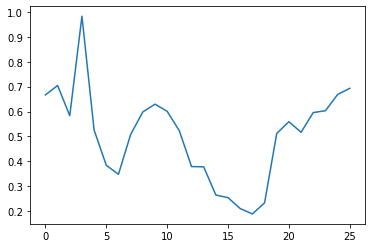

In [11]:
m.fig()
plt.plot(lls)
plt.show()

In [12]:
# plot the latents over the trials to see if anything improved
R = mutils.construct_R_matrix(data)
Z = mutils.construct_Z_matrix(R, big_model, num_latents=3)

<Figure size 432x288 with 0 Axes>

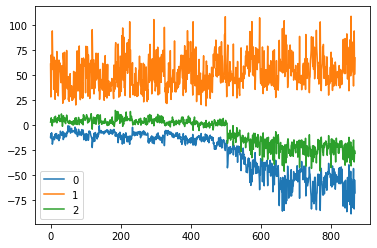

In [13]:
m.fig()
plt.plot(np.mean(Z, axis=1).T[0], label='0')
plt.plot(np.mean(Z, axis=1).T[1], label='1')
plt.plot(np.mean(Z, axis=1).T[2], label='2')
plt.legend()
plt.show()

# TODO: cut out the timepoints above ~500 where the drift begins

# TODO: retrain w/o drift network and with drift network and see what we get

# Package GLM in a parallel FFnetwork, and then have a third network to combine them using an add-layer

In [14]:
glm_layer_lin = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False, initialize_center=True,
    NLtype='lin' )
glm_layer_lin['reg_vals'] = {'d2xt': 0.02, 'bcs':{'d2xt': 1}}
glm_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer_lin] )

comb_layer = ChannelLayer.layer_dict(
    num_filters = data.NC, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( xstim_n = None, ffnet_n=[0,1], layer_list = [comb_layer], ffnet_type='add')

In [15]:
glmD0 = NDN.NDN( ffnet_list = [glm_net, drift_net, comb_net], loss_type='poisson')
# Copy drift from drift_mod and do not fit
# stuff the pretrained drift model weights into the drift_net component
glmD0.networks[1].layers[0].weight.data = deepcopy(drift_mod.networks[0].layers[0].weight.data)
glmD0.set_parameters(val=False,name='weight',ffnet_target=2)
glmD0.set_parameters(val=False,ffnet_target=1)
glmD0.fit( data, force_dict_training=True, **lbfgs_pars, verbose=0)
# Evaluate model using null-adjusted log-likelihood 
LLs0 = glmD0.eval_models(data[data.val_inds], null_adjusted=False)
print("LLs:", np.mean(LLsNULL-LLs0))

NameError: name 'lbfgs_pars' is not defined

In [ ]:
ws = glmD0.get_weights()
utils.ss(5,6)

for cc in range(data.NC):
    plt.subplot(5,6, cc+1)
    utils.imagesc(ws[:,:,cc])
    plt.colorbar()
plt.show()

# Something else

In [ ]:
NA = data.Xdrift.shape[1]
drift_pars1 = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} }

# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )
drift_netN =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1N] )

In [ ]:
# Fit one at a time
cc = 8
data.cells_out = [cc]
drift_mod = NDN.NDN( ffnet_list = [drift_netN], loss_type='poisson')
# Check out all the parameters in the model
#drift_mod.list_parameters()
drift_mod.fit( data, force_dict_training=True, **lbfgs_pars, verbose=2)
# Evaluate model using null-adjusted log-likelihood 
LLsNULL1 = drift_mod.eval_models(data[data.val_inds], null_adjusted=False)[0]
print(LLsNULL[cc], LLsNULL1)

In [ ]:
glm_layer_lin = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False, initialize_center=True,
    NLtype='lin' )
glm_layer_lin['reg_vals'] = {'d2xt': 0.02, 'bcs':{'d2xt': 1}}
glm_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer_lin] )

In [ ]:
glmD0.plot_filters()

# SCRATCH